In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

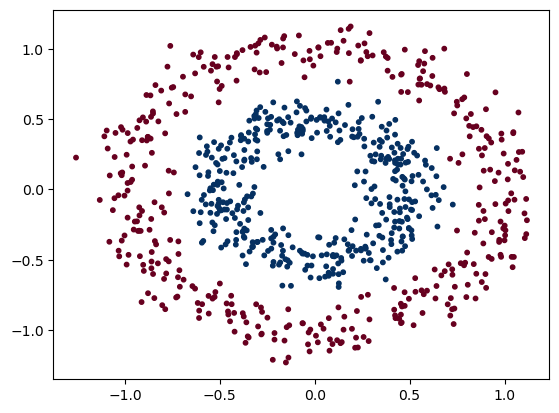

In [3]:
# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

In [78]:
# Define the overly complicated MLP
# class LargeMLP(nn.Module):
#     def __init__(self):
#         super(LargeMLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(2, 5),
#             nn.ReLU(),
#             nn.Linear(5, 6),
#             nn.ReLU(),
#             nn.Linear(6, 5),
#             nn.ReLU(),
#             nn.Linear(5, 7),
#             nn.ReLU(),
#             nn.Linear(7, 2),
#             # nn.ReLU()
#         )

#     def forward(self, x):
#         model.layers()
#         return self.layers(x)

model = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 7),
    nn.ReLU(),
    nn.Linear(7, 6),
    nn.ReLU(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.Sigmoid()
)
# model = nn.Sequential(
#     nn.Linear(2, 4),
#     nn.ReLU(),
#     nn.Linear(4, 5),
#     nn.ReLU(),
#     nn.Linear(5, 4),
#     nn.ReLU(),
#     nn.Linear(4, 7),
#     nn.ReLU(),
#     nn.Linear(7, 2),
#     nn.Sigmoid()
# )
print(model)


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=2, bias=True)
  (9): Sigmoid()
)


In [80]:
for name, param in model.named_parameters():
	if param.requires_grad:
		print(param)

Parameter containing:
tensor([[-0.1100,  0.2595],
        [ 0.3532,  0.2283],
        [ 0.6346, -0.1755],
        [ 0.1579,  0.2009],
        [ 0.0582, -0.2870]], requires_grad=True)
Parameter containing:
tensor([-0.6908,  0.2276,  0.4611, -0.6227, -0.1273], requires_grad=True)
Parameter containing:
tensor([[ 0.1329,  0.1306,  0.1388, -0.1016, -0.2770],
        [ 0.4067, -0.0643,  0.4401, -0.2124, -0.4031],
        [ 0.3837,  0.1939,  0.0959,  0.3390,  0.0635],
        [ 0.1967, -0.0664,  0.0740, -0.3901, -0.3895],
        [ 0.2687,  0.2349, -0.3702,  0.3045, -0.1711],
        [ 0.3260, -0.0501, -0.1899, -0.1511,  0.0609],
        [ 0.0890, -0.1443,  0.4062,  0.0584,  0.3092]], requires_grad=True)
Parameter containing:
tensor([ 0.1248, -0.0151,  0.1397,  0.0893,  0.2640, -0.0391, -0.1900],
       requires_grad=True)
Parameter containing:
tensor([[ 0.2491, -0.3178,  0.1468,  0.0651,  0.0667, -0.1536, -0.1144],
        [ 0.2635,  0.2293,  0.3519,  0.2260, -0.1994,  0.3331,  0.3251],
    

In [5]:
# Instantiate the model
# model = LargeMLP()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.4057, Val Loss: 0.4228
Epoch [200/1000], Loss: 0.3542, Val Loss: 0.3757
Epoch [300/1000], Loss: 0.3380, Val Loss: 0.3601
Epoch [400/1000], Loss: 0.3305, Val Loss: 0.3525
Epoch [500/1000], Loss: 0.3264, Val Loss: 0.3486
Epoch [600/1000], Loss: 0.3238, Val Loss: 0.3463
Epoch [700/1000], Loss: 0.3221, Val Loss: 0.3444
Epoch [800/1000], Loss: 0.3209, Val Loss: 0.3430
Epoch [900/1000], Loss: 0.3201, Val Loss: 0.3422
Epoch [1000/1000], Loss: 0.3194, Val Loss: 0.3414


In [8]:
torch.save(model.state_dict(), 'model.pickle')

In [81]:
# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.5

In [42]:
# Apply L1 structured pruning
from torch.nn.utils import prune

# Specify the amount of pruning
amount = 0.5

# Prune the model
for module in model.layers:
    if isinstance(module, nn.Linear):
        prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)

# Print sparsity of each layer
for module in model.layers:
    if isinstance(module, nn.Linear):
        print(f"Sparsity in {module}: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")


Sparsity in Linear(in_features=2, out_features=6, bias=True): 50.00%
Sparsity in Linear(in_features=6, out_features=5, bias=True): 40.00%
Sparsity in Linear(in_features=5, out_features=5, bias=True): 40.00%
Sparsity in Linear(in_features=5, out_features=5, bias=True): 40.00%
Sparsity in Linear(in_features=5, out_features=6, bias=True): 50.00%
Sparsity in Linear(in_features=6, out_features=2, bias=True): 50.00%


In [74]:
prune_ratio = 0.4
pruned_model = nn.Sequential()
pruned_layers = []
input_shape = 2

for name, param in model.named_parameters():
	if 'weight' in name:
		if param.shape[0] == 2:
			layer = nn.Linear(input_shape, 2)
			with torch.no_grad():
				layer.data = param.data
			pruned_layers.append(layer)
			pruned_layers.append(nn.ReLU())
			continue
		
		print(param.data)
		sorted_layers = torch.linalg.norm(param.data, ord=1, dim=1).argsort(dim=-1)
		print(sorted_layers)
		layers_not_pruned = sorted(sorted_layers[int(prune_ratio*param.data.shape[0]):])
		layer_data = param.data[layers_not_pruned,:]
		layer = nn.Linear(input_shape, layer_data.shape[0])
		input_shape = layer_data.shape[0]
		with torch.no_grad():
			layer.data = layer_data
		pruned_layers.append(layer)
		pruned_layers.append(nn.ReLU())

print(pruned_layers)
pruned_model = nn.Sequential(*pruned_layers)
print(pruned_model[0].data)

tensor([[ 0.0952, -0.1868],
        [-0.5512, -1.5645],
        [ 1.9446,  0.2974],
        [-0.0964, -0.4462],
        [-1.5862,  1.8505]])
tensor([0, 3, 1, 2, 4])
tensor([[ 0.1376, -0.1087,  0.1034, -0.4358,  0.1435],
        [-0.2585,  0.0521, -0.0449,  0.3482, -0.3190],
        [ 1.2147, -0.5599, -1.0864,  0.1668, -0.8130],
        [-0.0779,  1.5342,  1.5511, -0.2188,  0.7680],
        [-0.5126,  1.4150,  0.8987, -0.3601,  0.8323],
        [ 0.6755, -1.0899, -1.1656, -0.2620, -1.1971],
        [-0.8579,  1.6689,  0.8948,  0.1957,  1.1920]])
tensor([0, 1, 2, 4, 3, 5, 6])
tensor([[ 0.2700,  0.1200,  1.4213, -1.4511, -1.5463,  1.4482, -1.4397],
        [-0.2372,  0.0492, -0.9843,  1.2914,  1.3674, -1.0618,  1.3244],
        [ 0.0039,  0.0901,  0.0646, -0.1221, -0.0934, -0.0950, -0.1138],
        [-0.0693,  0.3615, -0.0369, -0.2007, -0.0670,  0.1849, -0.2453],
        [-0.1723, -0.3471, -0.3249,  1.2521,  1.0974, -1.0881,  0.8509],
        [ 0.0146,  0.1717, -0.0511, -0.0096, -0.2767, 

In [75]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pruned_model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # model.train()
    optimizer.zero_grad()
    outputs = pruned_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        pruned_model.eval()
        with torch.no_grad():
            val_outputs = pruned_model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [200/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [300/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [400/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [500/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [600/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [700/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [800/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [900/1000], Loss: 0.6931, Val Loss: 0.6931
Epoch [1000/1000], Loss: 0.6931, Val Loss: 0.6931


In [77]:
# torch.unique(model(X_val_tensor))
y_val_outputs = pruned_model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.5